# CSCI E-82 HW-5 Part-2 

**Janice Pham, Nitesh Kumar**

**Summary :**

**In this notebook we explored two density based models HDBSCAN and Gaussian Mixture Model. Both are soft clustering method. They assign each case with a probability of it belonging to a cluster. HDBSCAN however only gives the probability with which it was assigned to a cluster for each case. GMM provides it's probabilities for all clusters.** 

**In our first notebook we explored the embeddings from sci-bert and bio-bert.  In this notebook we explored sentence bert and bio-bert. We tried umap to reduce the dimension of embedding for both sentence, and bio-bert embeddings.** 

#### Preprocessing:
**Spacy to remove stop words, punctuation and special characters. We also lemmatized each word.** 

#### Embedding:
**Sentence embedding and Bio-Bert Embedding.**

#### Models with Dimensionality Reduction:
**HDBSCAN with Sentence Embedding:**
**We performed a random search on hyperparams for both UMAP and HDBSCAN to find the appropriate cluster size.**

#### HDBSCAN with Bio-Bert Embedding:
**We performed a random search on hyperparams for both UMAP and HDBSCAN to find the appropriate cluster size.**

#### GMM with BioBert:
**For this we searched for n_components as our hyperparams to find the best model. We used the same UMAP embedding from previous step.** 

#### GMM with Sentence embedding and Bio Bert with no dimensionality reduction:

**We searched for the best n_components hyperparams. We use covariance as full to allow the model to look for wide
elliptical plane for clustering.** 


#### Model Selection :
##### HDBSCAN:
**We used a variety of metrics for this. We used a custom scoring to check how many cases have assigned probabilities that is greater less than 0.5. We also used coverage, i.e how are cases covered in each cluster.
We also evaluated silhouette score, and adjency information score , and looked at it visually. We also
looked at our clusters both in excel file to check how well the clusters were working.**


##### GMM:
**Similar approach as above. For this we looked at AIC, BIC and likelihood score for each model in addition to
silhouette and adjancy information score.** 


#### Testing:
**We evaluated our model on the test set provided. We looked at number of cluster assigned to test data. 
Models with dimensionality reduction performed poorly. Our final model from this part was GMM with 92 components
and trained on Bio-Bert embedding with no dimensionality reduction.** 












In [162]:
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

#nltk
import nltk
from nltk.corpus import stopwords

#spacy
import spacy
nlp = spacy.load("en_core_web_sm")

#transformers
from sentence_transformers import SentenceTransformer, util

from transformers import pipeline
from transformers import BertTokenizer, TFBertForSequenceClassification, AutoTokenizer, AutoModel, AutoModelForSequenceClassification
from transformers import InputExample, InputFeatures


#sklearn
from sklearn.cluster import KMeans, DBSCAN, MeanShift
from sklearn.neighbors import NearestNeighbors, NearestCentroid
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.metrics import  adjusted_mutual_info_score



# Scipy
import scipy.cluster.hierarchy as hac
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import dendrogram, linkage

from sklearn.manifold import TSNE
from sklearn.manifold import MDS
from sklearn.manifold import Isomap
import umap
import hdbscan

from sklearn.metrics import euclidean_distances


from yellowbrick.cluster import SilhouetteVisualizer

from word_mover_distance import model

#### Basic EDA, most was it performed on the first notebook. 

In [2]:
df = pd.read_csv("asthma_exclusion.txt", sep='\t')
df.head()

NCT#    phase                                         condition  \
0  NCT01650441  Phase 2                                            Asthma   
1  NCT02162784  Phase 2                                            Asthma   
2  NCT02740543  Phase 2                                            Asthma   
3  NCT02227394  Phase 2  Asthma;Asthma Chronic;Asthma Bronchial;Asthmatic   
4  NCT00465413  Phase 2                                            Asthma   

                        sponsor start_date mesh_list  \
0  University Hospital, Antwerp  10-Feb-15    Asthma   
1          Intech Biopharm Ltd.  10-Feb-15    Asthma   
2            NYU Langone Health  10-Feb-15    Asthma   
3                    Zambon SpA  10-Feb-15    Asthma   
4      Mackay Memorial Hospital  10-Feb-15       NaN   

                                           criterion  Ground_Truth  
0  Inability to carry out pulmonary function testing           0.0  
1  Inability to carry out pulmonary function test...           0.0  
2  Inability to perform lung function or other ma...           0.0  
3  Patient unable to perform pulmonary function t...           0.0  
4   poor performance of pulmonary function testing.            0.0

In [3]:
df['Ground_Truth'].value_counts()

15.0     141
42.0     129
21.0     121
2.0      101
6.0       98
        ... 
63.0       1
62.0       1
59.0       1
35.0       1
889.0      1
Name: Ground_Truth, Length: 96, dtype: int64

In [4]:
nan_df =df["Ground_Truth"].isna()

df = df[~nan_df]

In [5]:
criterion_length = [len(i) for i in df['criterion'].str.split()]
np.argmax(criterion_length)

161

In [6]:
df.shape

(2428, 8)

In [7]:
df.drop(161, axis=0, inplace=True)

In [8]:
#change case

In [9]:
df.shape

(2427, 8)

### Load the modified df

In [2]:
df = pd.read_csv("modified_asthma.csv")
df.shape

(2427, 8)

In [3]:
df.head(2)

NCT#    phase condition                       sponsor start_date  \
0  NCT01650441  Phase 2    Asthma  University Hospital, Antwerp  10-Feb-15   
1  NCT02162784  Phase 2    Asthma          Intech Biopharm Ltd.  10-Feb-15   

  mesh_list                                          criterion  Ground_Truth  
0    Asthma  Inability to carry out pulmonary function testing           0.0  
1    Asthma  Inability to carry out pulmonary function test...           0.0

In [4]:
df['criterion'] =df['criterion'].replace('[^A-za-z0-9]', ' ', regex=True)

### Sentence Preprocessing using spacy. 
Remove special character, stop words, and lemmatize each word in the sentnce.

In [5]:
spacy_wo_stop_punct_lemma = []

for val in df['criterion']:
    doc = nlp(val)
    criterion = ""
    
    for token in doc:
        if not token.is_space:
            if not token.is_stop:
                if not token.is_punct:
                    if not token.is_digit:
                        criterion +=" "+token.lemma_
    spacy_wo_stop_punct_lemma.append(criterion.strip().lower())
    
                
df['spacy_wo_stop_punct_lemma'] = spacy_wo_stop_punct_lemma



In [6]:
df.shape

(2427, 9)

In [7]:
df['criterion'].iloc[0]

'Inability to carry out pulmonary function testing'

In [8]:
df['spacy_wo_stop_punct_lemma'].iloc[0]

'inability carry pulmonary function testing'

In [9]:
df.isna().sum()

NCT#                          0
phase                         0
condition                     0
sponsor                       0
start_date                    0
mesh_list                    73
criterion                     0
Ground_Truth                  0
spacy_wo_stop_punct_lemma     0
dtype: int64

### Create embeddings for sentences. 
Sentence embedding, sci bert, and bio bert are used. However, for this part we used only sentence embedding, and
bio-bert embeddings.

In [10]:
model_sentence_transformer = SentenceTransformer("all-MiniLM-L6-v2")

embeddings_criterion = model_sentence_transformer.encode(df['criterion'].tolist())
embeddings_criterion1 = model_sentence_transformer.encode(df['spacy_wo_stop_punct_lemma'].tolist())


with open('sen_criterion.npy', 'wb') as f:
    np.save(f, embeddings_criterion)
    
with open('sen_criterion1.npy', 'wb') as f:
    np.save(f, embeddings_criterion1)


In [11]:
model_scibert = 'allenai/scibert_scivocab_uncased'
scibert_transformer_model = SentenceTransformer(model_scibert)

model_biobert = 'dmis-lab/biobert-base-cased-v1.2'
biobert_transformer_model = SentenceTransformer(model_biobert)

No sentence-transformers model found with name /home/riku/.cache/torch/sentence_transformers/allenai_scibert_scivocab_uncased. Creating a new one with MEAN pooling.
Some weights of the model checkpoint at /home/riku/.cache/torch/sentence_transformers/allenai_scibert_scivocab_uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly iden

In [12]:
sci_embed_criterion = scibert_transformer_model.encode(df['criterion'].tolist())
sci_embed_criterion1 = scibert_transformer_model.encode(df['spacy_wo_stop_punct_lemma'].tolist())


with open('sci_criterion.npy', 'wb') as f:
    np.save(f, sci_embed_criterion)
    
with open('sci_criterion1.npy', 'wb') as f:
    np.save(f, sci_embed_criterion1)
    

In [13]:
bio_embed_criterion = biobert_transformer_model.encode(df['criterion'].tolist())
bio_embed_criterion1 = biobert_transformer_model.encode(df['spacy_wo_stop_punct_lemma'].tolist())


with open('bio_criterion.npy', 'wb') as f:
    np.save(f, bio_embed_criterion)
        
with open('bio_criterion1.npy', 'wb') as f:
    np.save(f, bio_embed_criterion1)


    

In [62]:
#Load embedded files

### Load the saved embeddings

In [15]:
with open('sci_criterion.npy', 'rb') as f:
     sci_embed_criterion= np.load(f)

with open('sci_criterion1.npy', 'rb') as f:
     sci_embed_criterion1= np.load(f)


with open('bio_criterion.npy', 'rb') as f:
     bio_embed_criterion= np.load(f)

with open('bio_criterion1.npy', 'rb') as f:
     bio_embed_criterion1= np.load(f)


with open('sen_criterion.npy', 'rb') as f:
     sen_embed_criterion= np.load(f)

with open('sen_criterion1.npy', 'rb') as f:
     sen_embed_criterion1= np.load(f)



### Model Training
**In this part we explored 2 models HDBSCAN and GMM. We used UMAP as our dimensionality reduction technique.
We trained both UMAP and HDBSCAN clustering algorithm on hyperparams by doing a random search with 75 different combinations. We used both sentence embedding, and bio-bert. For each type of embedding we performed separate
random search to find best hyperparams for both UMAP and HDBSCAN**


### UMAP with HDBSCAN


In [30]:
#create umap embeddings with given params, and train a hdbscan clustering model
def umap_with_hdbscan(embedding,n_neigbors, n_components, 
                      cluster_size_minimum, 
                      min_samples,
                      umap_metric ='cosine',
                      cluster_metric='euclidean',
                      cluster_method ='eom'):
    
    umap_model = umap.UMAP(n_neighbors= n_neigbors,
                          n_components= n_components,
                          random_state=1,
                          metric = umap_metric
                         )
    
    umap_fit = umap_model.fit_transform(embedding)
    
    hdbscan_cluster = hdbscan.HDBSCAN(min_cluster_size= cluster_size_minimum, metric= cluster_metric,
                                     cluster_selection_method=cluster_method, min_samples = min_samples,
                                      gen_min_span_tree=True,prediction_data=True).fit(umap_fit)
    
    return hdbscan_cluster, umap_fit


# do random search on parameters. 75 different combinations are tried.
#returns a dataframe with the hyperams trained, and scores used to evaluate
#how well a model is performing.
def search_for_hyperparams(embedding,method,search_area):
    
    attribute_list = []
    cluster_list = []
    umap_data_list = []
    if method =='hdbscan':
        for i in range(75):
            n_neighbors = np.random.choice(search_area['n_neighbors'])
            n_components = np.random.choice(search_area['n_components'])
            cluster_size_minimum = np.random.choice(search_area['cluster_size_minimum'])
            min_samples = np.random.choice(search_area['min_samples'])
            
            cluster, umap_data = umap_with_hdbscan(embedding,n_neighbors,n_components,cluster_size_minimum,\
                                                  min_samples)
            n_clusters = len(np.unique(cluster.labels_))
            
            score = np.sum(cluster.probabilities_ < 0.5)
            score = score / len(cluster.labels_)
            
            coverage = cluster.labels_ >=0
            coverage = np.sum(coverage) / len(cluster.labels_)
            dbcv_score = cluster.relative_validity_
            
            attribute_list.append([ n_neighbors, n_components, cluster_size_minimum,n_clusters, \
                                   score, coverage, dbcv_score])
            cluster_list.append(cluster)
            umap_data_list.append(umap_data)
    df_clustering_results = pd.DataFrame(attribute_list, \
                                         columns = ['n_neighbors', 'n_components', 'cluster_size_minimum'
                                                    ,'n_clusters', 'score', 'coverage', 'dbcv_score'])
    
    return df_clustering_results, cluster_list, umap_data_list
               

### Train hdbscan with sentence embedding using UMAP with the given search params

In [31]:
search_area = {'n_neighbors': np.arange(8, 16),
               'n_components':np.arange(5,12),
            'cluster_size_minimum':np.arange(5, 20),
            'min_samples':range(1,10)
              }

df_results, hdbscan_list, umap_data_list = search_for_hyperparams(sen_embed_criterion1,'hdbscan', search_area)


In [55]:
df_results[(df_results['n_clusters'] > 70) & (df_results['n_clusters'] < 110) ].sort_values(by='dbcv_score',\
                                                                                            ascending=False)

n_neighbors  n_components  cluster_size_minimum  n_clusters     score  \
63           11            10                    10          74  0.157808   
69            8            10                     8          75  0.197775   
45           10            10                    11          82  0.170581   
2            11             7                    10          86  0.231562   
11           13             6                     7          84  0.209312   
66            8             8                    10          88  0.164813   
71            8             8                    10          95  0.186650   
3             9             6                    11          71  0.169345   
42            9             8                     5         109  0.202719   
23           10            10                     9          97  0.182942   
32           13             6                    10          72  0.185826   
47            8            11                     9          77  0.192007   
41           14             6                    10          78  0.156572   
54           15             5                     7         109  0.257108   
30           14             9                     9          71  0.167285   
73           14             8                     8          79  0.189946   

    coverage  dbcv_score  
63  0.904409    0.482257  
69  0.873506    0.477273  
45  0.917182    0.450662  
2   0.864442    0.448616  
11  0.894520    0.442966  
66  0.913885    0.432401  
71  0.915534    0.430073  
3   0.908529    0.426421  
42  0.881335    0.416932  
23  0.898640    0.406294  
32  0.933251    0.405919  
47  0.890400    0.374262  
41  0.934487    0.369114  
54  0.873506    0.347125  
30  0.915122    0.339041  
73  0.900288    0.330927

In [56]:
idx = np.array(df_results[(df_results['n_clusters'] > 70) & \
                    (df_results['n_clusters'] < 110) ].sort_values(by='dbcv_score', ascending=False).index)

silh_list = []

for i in idx:
    score = silhouette_score(umap_data_list[i], hdbscan_list[i].labels_, metric='cosine')
    silh_list.append(score)
    
    
adj_list = []

for i in idx:
    score = adjusted_mutual_info_score(df['Ground_Truth'], hdbscan_list[i].labels_)
    adj_list.append(score)
    



Text(0.5, 1.0, 'Adj. Mutual score for models using UMAP and HDBSCAN')

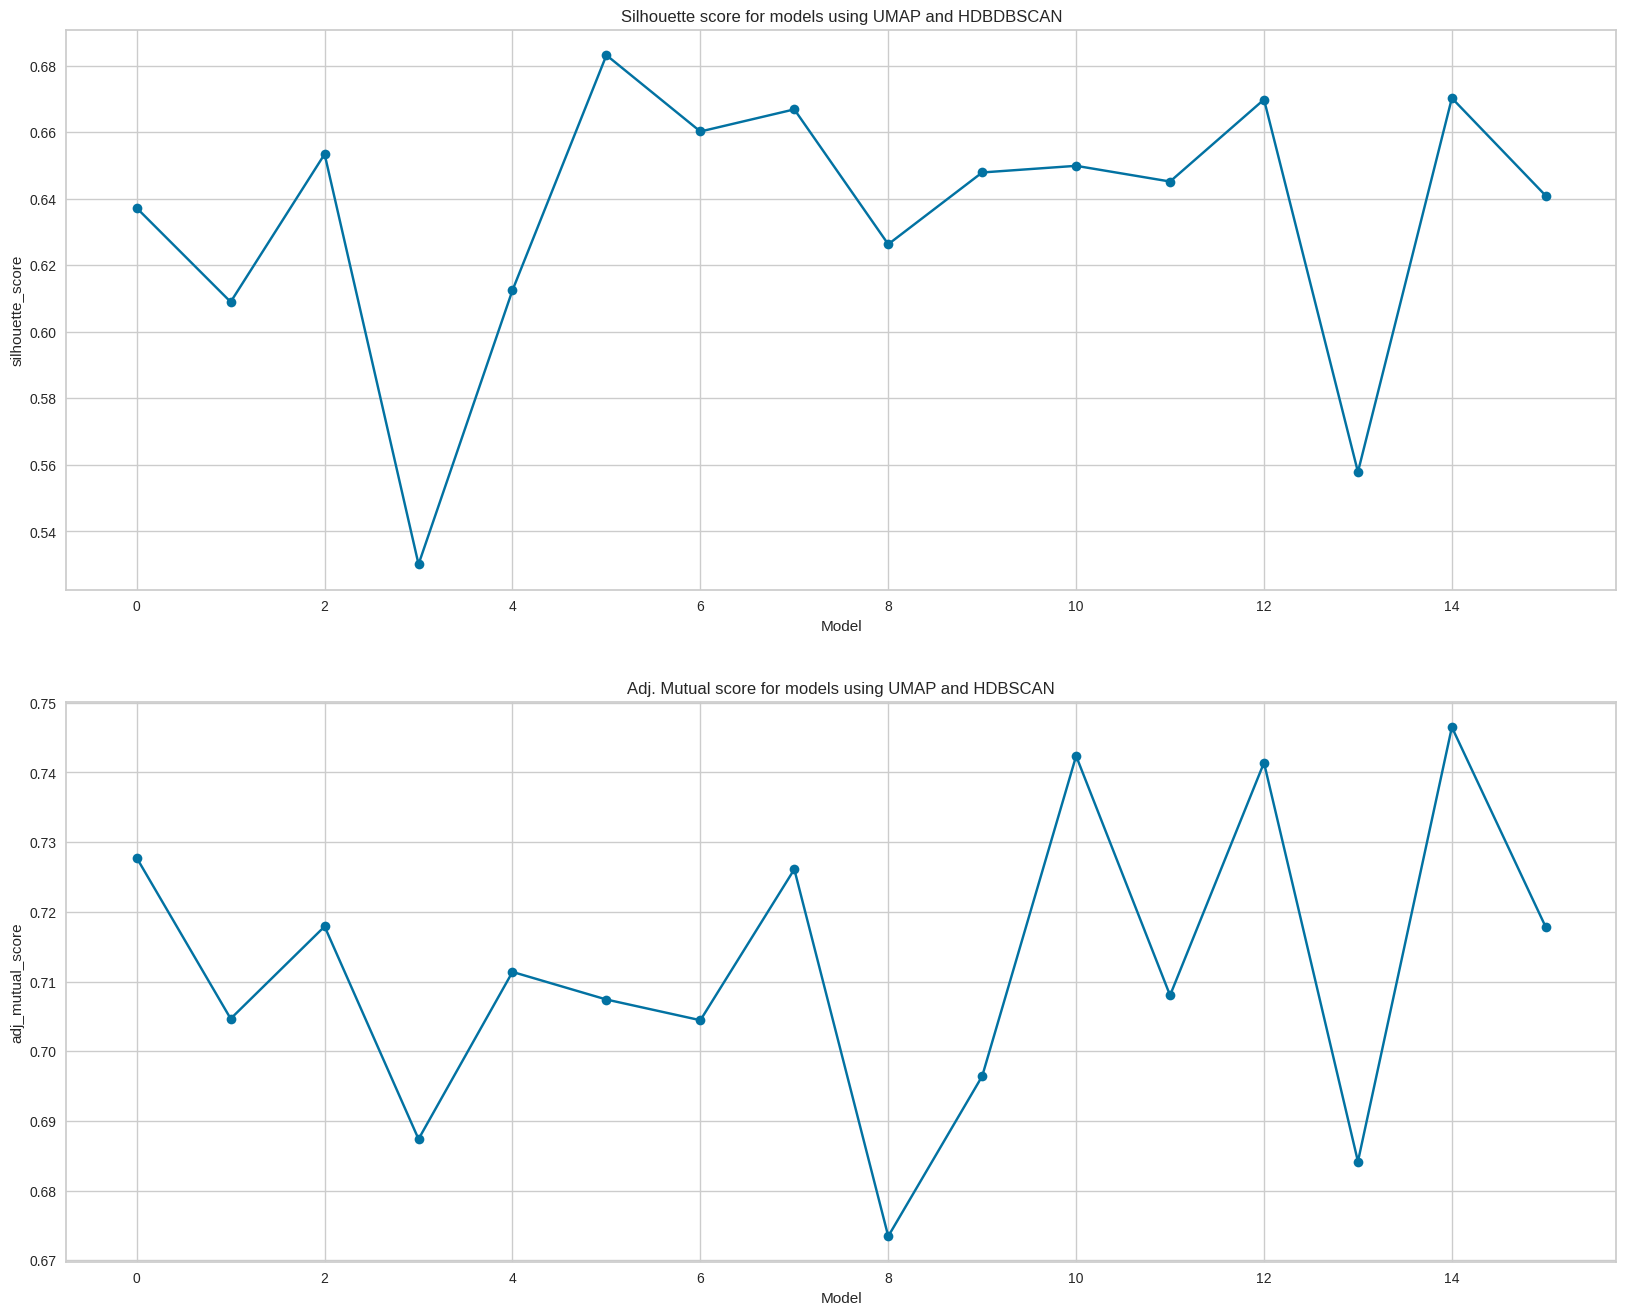

In [57]:
fig, axs = plt.subplots(2,1, figsize=(20, 16))
axs = axs.ravel()


axs[0].plot(range(len(silh_list)), silh_list, marker='o')
axs[0].set_xlabel('Model')
axs[0].set_ylabel('silhouette_score')
axs[0].set_title("Silhouette score for models using UMAP and HDBDBSCAN")

axs[1].plot(range(len(adj_list)), adj_list, marker='o')
axs[1].set_xlabel('Model')
axs[1].set_ylabel('adj_mutual_score')
axs[1].set_title("Adj. Mutual score for models using UMAP and HDBSCAN")

**In the above charts x-axis is simply and index from the filtered results. We trained the model doing a random search, with variety of hyperparams for both umap and hdbscan. There was no good way to show that data on x-axis. For model selection I matched the index with the filtered dataframe.**

**From all the models trained, We find that the model with the best silhouette, adj. mutual score, and metrics such as coverage is the model with UMAP params 8 neighbors, 8 components, and 95 clusters.**

In [58]:
idx_best_model = 71

df_hdbscan = pd.DataFrame({
    'criterion':df['spacy_wo_stop_punct_lemma'].tolist(),
     'label':hdbscan_list[idx_best_model].labels_,
      'proba':hdbscan_list[idx_best_model].probabilities_,
      'outlier_score': hdbscan_list[idx_best_model].outlier_scores_,
      'ground_truth':df['Ground_Truth'].tolist()})



In [59]:
df_hdbscan.to_excel('hdbscan_df.xlsx', index=False)

In [60]:
df_hdbscan[df_hdbscan['proba'] ==1].shape


(1510, 5)

In [61]:
df_hdbscan[df_hdbscan['proba'] < 0.5].shape

(453, 5)

In [62]:
df_hdbscan[df_hdbscan['label'] ==-1]

criterion  label  proba  \
21    history suggestive diagnosis concomitant lung ...     -1    0.0   
25    presence active infectious disease judge inves...     -1    0.0   
112   subject history physician diagnose panic disor...     -1    0.0   
128               treatment antagonist include eye drop     -1    0.0   
129   current use adrenergic antagonist e g propranolol     -1    0.0   
...                                                 ...    ...    ...   
2405                 diagnosis restrictive lung disease     -1    0.0   
2406                 diagnosis restrictive lung disease     -1    0.0   
2407                 diagnosis restrictive lung disease     -1    0.0   
2408                 diagnosis restrictive lung disease     -1    0.0   
2426                 diagnosis restrictive lung disease     -1    0.0   

      outlier_score  ground_truth  
21         0.062728           1.0  
25         0.102433           1.0  
112        0.060575           2.0  
128        0.338725           3.0  
129        0.338725           3.0  
...             ...           ...  
2405       0.062728          89.0  
2406       0.062728          89.0  
2407       0.062728          89.0  
2408       0.062728          89.0  
2426       0.062728          89.0  

[205 rows x 5 columns]

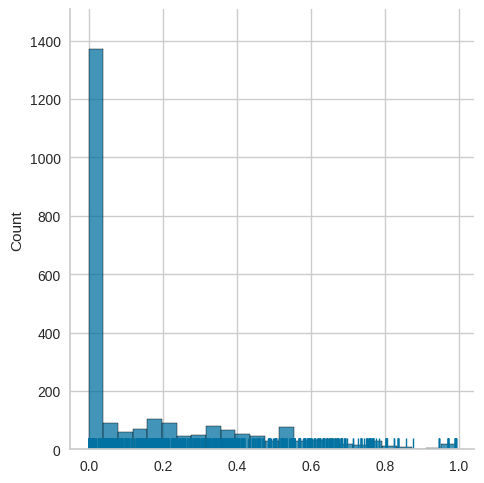

In [63]:
sns.displot(hdbscan_list[idx_best_model].outlier_scores_[np.isfinite(hdbscan_list[idx_best_model].outlier_scores_)], rug=True)

In [45]:
df_hdbscan[df_hdbscan['outlier_score'] >0.8]

criterion  label     proba  \
114   subject history substance abuse drug abuse mon...     10  0.054139   
115   subject history substance abuse drug abuse mon...     10  0.054139   
116   subject history substance abuse drug abuse mon...     10  0.054139   
117   subject history substance abuse drug abuse mon...     10  0.054139   
160                                   treatment blocker     57  0.189099   
753               pregnant woman breast feeding lactate     11  0.177852   
910                    history primary immunodeficiency      2  0.012450   
911                    history primary immunodeficiency      2  0.012450   
912                    history primary immunodeficiency      2  0.012450   
913                    history primary immunodeficiency      2  0.012450   
914                    history primary immunodeficiency      2  0.012450   
934            subject history primary immunodeficiency      2  0.012450   
1096              history hypersensitivity milk product     40  0.191094   
1113  history allergic reaction know hypersensitivit...     40  0.191094   
1120  history immediate delay hypersensitivity react...     40  0.191094   
1126  history hypersensitivity study treatment excip...     40  0.191094   
1157  know hypersensitivity formoterol lactose metha...     40  0.191094   
1165  know suspect hypersensitivity imps excipient i...     40  0.191094   
1402  use prohibit drug failure observe drug washout...      2  0.010306   
1403  use prohibit drug failure observe drug washout...      2  0.010306   
1404  use prohibit drug failure observe drug washout...      2  0.010306   
1405  use prohibit drug failure observe drug washout...      2  0.010306   
1624  administration parenteral intravenous subcutan...     57  0.127669   
1748                                     body weight kg      6  0.038298   
1749                                     body weight kg      6  0.038298   
1750                                     body weight kg      6  0.038298   
1751                            body weight kilogram kg      6  0.038298   
1752                           patient weight kg screen      6  0.038298   
1753                                       weight kg kg      6  0.038298   
1754                                          weight kg      6  0.038298   
1755                              weight kilogram kg kg      6  0.038298   
1972  current prior diagnosis suspect diagnosis copd...     65  0.197785   

      outlier_score  ground_truth  
114        0.945861           2.0  
115        0.945861           2.0  
116        0.945861           2.0  
117        0.945861           2.0  
160        0.810901           4.0  
753        0.822148          16.0  
910        0.987550          20.0  
911        0.987550          20.0  
912        0.987550          20.0  
913        0.987550          20.0  
914        0.987550          20.0  
934        0.987550          20.0  
1096       0.808906          24.0  
1113       0.808906          24.0  
1120       0.808906          24.0  
1126       0.808906          24.0  
1157       0.808906          24.0  
1165       0.808906          24.0  
1402       0.989694          31.0  
1403       0.989694          31.0  
1404       0.989694          31.0  
1405       0.989694          31.0  
1624       0.872331          42.0  
1748       0.961702          43.0  
1749       0.961702          43.0  
1750       0.961702          43.0  
1751       0.961702          43.0  
1752       0.961702          43.0  
1753       0.961702          43.0  
1754       0.961702          43.0  
1755       0.961702          43.0  
1972       0.802215          50.0

**We visually inspected the outliers. The assigned outliers seemed to some scientific terms. We try Bio-Bert embedding next**

### HDBSCAN with BioBert

In [47]:
search_area_bio = {'n_neighbors': np.arange(8, 16),
               'n_components':np.arange(5,12),
            'cluster_size_minimum':np.arange(5, 20),
            'min_samples':range(1,10)
              }




df_results_bio, hdbscan_list_bio, umap_data_list_bio = search_for_hyperparams(bio_embed_criterion1,\
                                                                              'hdbscan', search_area_bio)


In [64]:
df_results_bio[(df_results_bio['n_clusters'] > 70) & \
               (df_results_bio['n_clusters'] < 110) ].sort_values(by='dbcv_score', ascending=False)

n_neighbors  n_components  cluster_size_minimum  n_clusters     score  \
26           12            10                     8         100  0.210136   
71           11            11                     8         100  0.222085   
57           15             5                    10          80  0.224969   
28           12             7                    11          71  0.228677   
64           10             5                     5          92  0.299959   
7            12             6                    12          74  0.187062   
13            8             9                    11          73  0.213020   
19           11             6                    10          77  0.218377   
37            8             6                     7          89  0.258756   
58            8             6                     9         104  0.234446   
9            10             5                    10          88  0.215080   
47           11             9                     6          84  0.257932   
23           10             5                    11          73  0.238566   
41           12             7                     6         109  0.253811   
27           14             6                    12          73  0.203131   
63           14             7                     6          86  0.285950   
1            12            10                    13          71  0.148331   
42            9             7                     5          94  0.257932   
67           12             8                     6          92  0.239390   
69           12            11                     8          99  0.235270   
15           12             9                    10          75  0.199423   

    coverage  dbcv_score  
26  0.864030    0.376527  
71  0.860321    0.376366  
57  0.896580    0.364987  
28  0.836424    0.357560  
64  0.817470    0.355930  
7   0.887103    0.355295  
13  0.844664    0.349742  
19  0.884631    0.349196  
37  0.824887    0.346504  
58  0.872682    0.343786  
9   0.873506    0.333978  
47  0.829007    0.330794  
23  0.855377    0.330511  
41  0.849609    0.330266  
27  0.889576    0.316442  
63  0.819942    0.314712  
1   0.903173    0.311443  
42  0.831479    0.310418  
67  0.870210    0.308171  
69  0.863206    0.292149  
15  0.875155    0.216299

In [65]:
idx = np.array(df_results_bio[(df_results['n_clusters'] > 70) & \
                    (df_results_bio['n_clusters'] < 110) ].sort_values(by='dbcv_score', ascending=False).index)

silh_list_bio = []

for i in idx:
    score = silhouette_score(umap_data_list_bio[i], hdbscan_list_bio[i].labels_, metric='cosine')
    silh_list_bio.append(score)
    
    
adj_list_bio = []

for i in idx:
    score = adjusted_mutual_info_score(df['Ground_Truth'], hdbscan_list_bio[i].labels_)
    adj_list_bio.append(score)
    


Text(0.5, 1.0, 'Adj. Mutual score for models using UMAP and HDBSCAN')

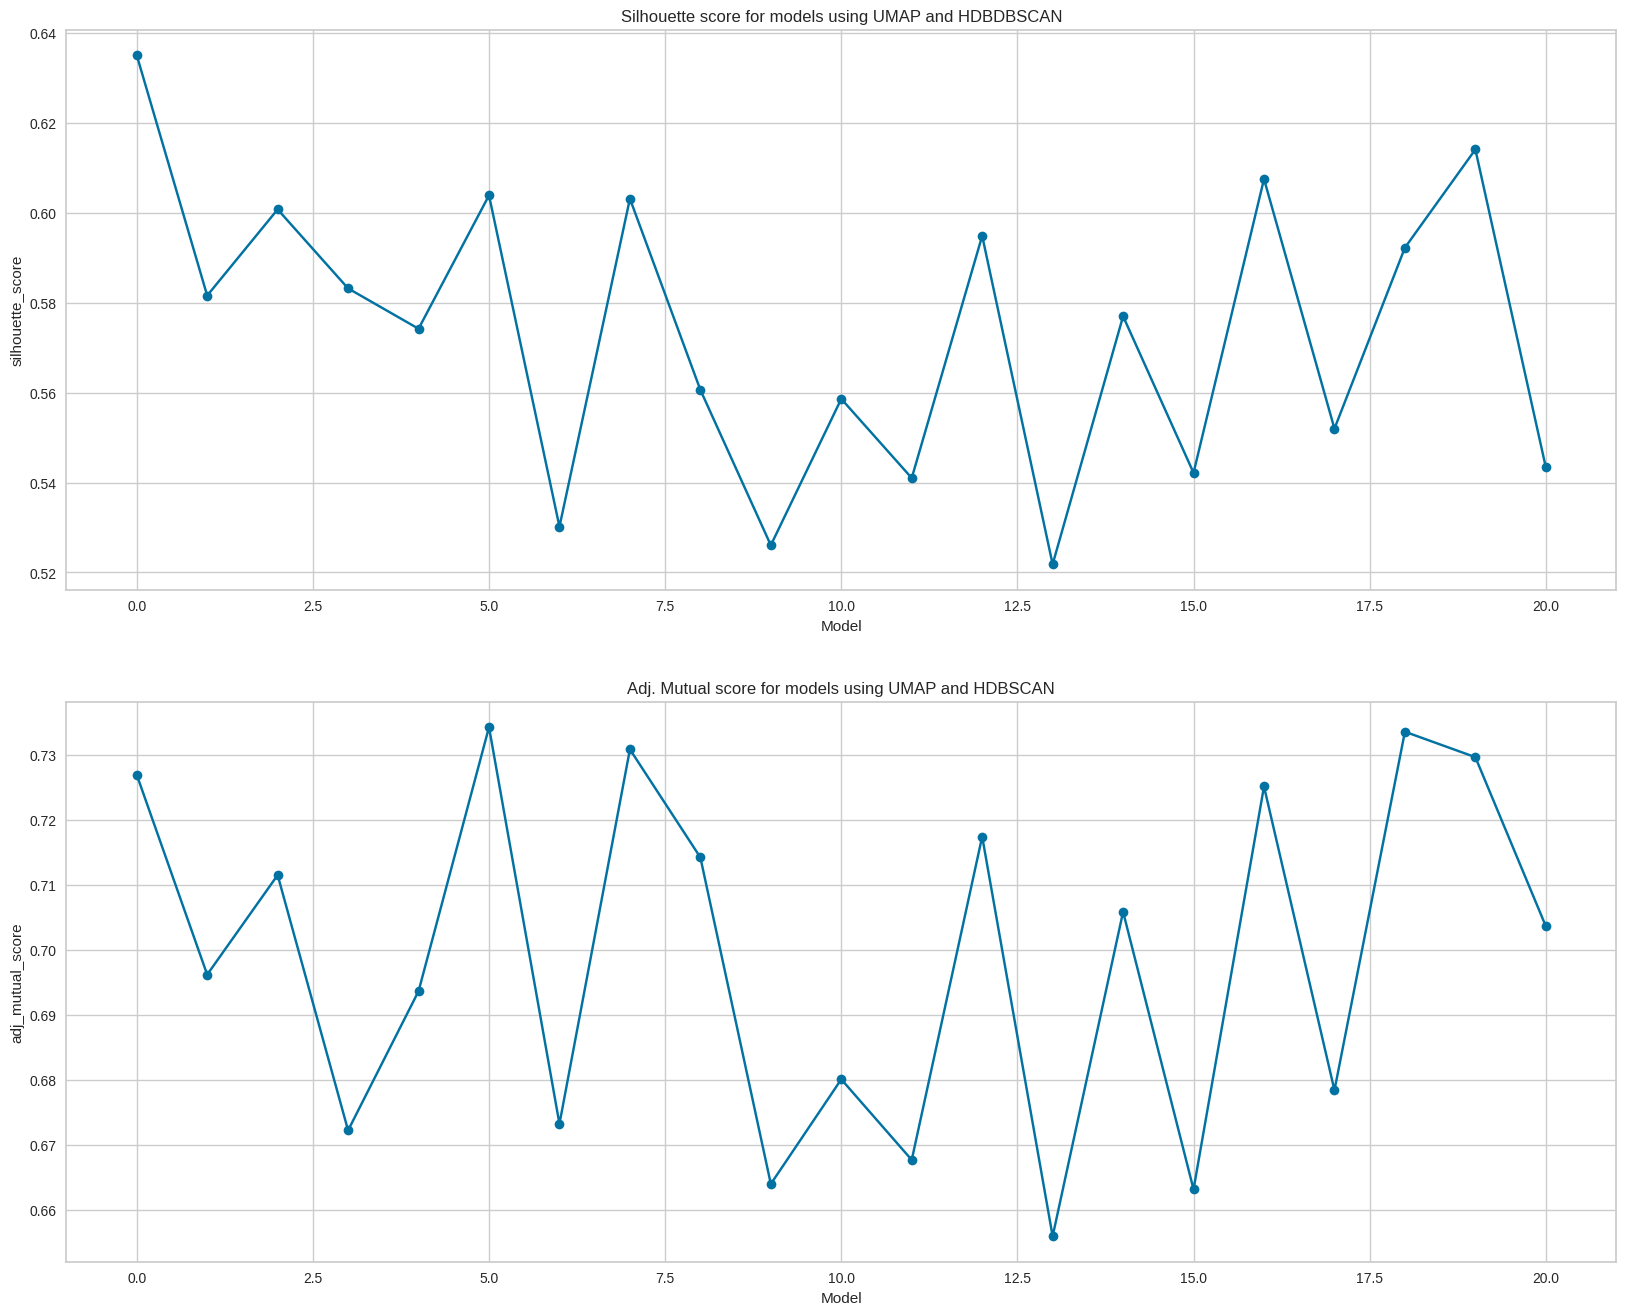

In [66]:
fig, axs = plt.subplots(2,1, figsize=(20, 16))
axs = axs.ravel()


axs[0].plot(range(len(silh_list_bio)), silh_list_bio, marker='o')
axs[0].set_xlabel('Model')
axs[0].set_ylabel('silhouette_score')
axs[0].set_title("Silhouette score for models using UMAP and HDBDBSCAN")

axs[1].plot(range(len(adj_list_bio)), adj_list_bio, marker='o')
axs[1].set_xlabel('Model')
axs[1].set_ylabel('adj_mutual_score')
axs[1].set_title("Adj. Mutual score for models using UMAP and HDBSCAN")


**Based on silhouette, adj. mutual score, coverage(i.e. how much coverage does the cluster have for all cases), and also how many cases have threshold < 0.5 we selected the best model to be with UMAP params 12 neighbors, 
10 components, and this gave us a cluster of 100.** 


In [71]:
idx_best_model = 26

df_hdbscan_bio = pd.DataFrame({
    'criterion':df['spacy_wo_stop_punct_lemma'].tolist(),
     'label':hdbscan_list_bio[idx_best_model].labels_,
      'proba':hdbscan_list_bio[idx_best_model].probabilities_,
      'outlier_score': hdbscan_list_bio[idx_best_model].outlier_scores_,
      'ground_truth':df['Ground_Truth'].tolist()})

In [72]:
df_hdbscan_bio.to_excel('df_hdbscan_bio.xlsx', index=False)

In [73]:
df_hdbscan_bio[df_hdbscan_bio['label'] ==-1]

criterion  label  proba  \
11    diagnosis suspect covid infection associated p...     -1    0.0   
16    history chronic cough haemoptysis weight loss ...     -1    0.0   
18    history active bacterial viral fungal infectio...     -1    0.0   
28                               use marijuana day year     -1    0.0   
42    current history suicidal ideation past history...     -1    0.0   
...                                                 ...    ...    ...   
2412                 inability speak understand english     -1    0.0   
2414          subject communicate reliably investigator     -1    0.0   
2416  inability unwillingness participant subject s ...     -1    0.0   
2417                     history cardiovascular disease     -1    0.0   
2426                 diagnosis restrictive lung disease     -1    0.0   

      outlier_score  ground_truth  
11         0.489869           1.0  
16         0.186601           1.0  
18         0.024183           1.0  
28         0.123258           2.0  
42         0.021013           2.0  
...             ...           ...  
2412       0.029187         101.0  
2414       0.023946         101.0  
2416       0.034976         103.0  
2417       0.164000         104.0  
2426       0.080768          89.0  

[330 rows x 5 columns]

In [74]:
df_hdbscan_bio[df_hdbscan_bio['outlier_score'] >0.9]

criterion  label     proba  \
261                        previous history asthma copd     36  0.091809   
705                                 pregnancy lactation      0  0.022040   
1317  receipt immunoglobulin blood product day rando...     -1  0.000000   
1318  receipt immunoglobulin blood product day rando...     -1  0.000000   
1319  receipt immunoglobulin blood product day rando...     -1  0.000000   
1320  receipt immunoglobulin blood product day prior...     -1  0.000000   
1321  receipt immunoglobulin blood product day prior...     -1  0.000000   
1322  subject receive immunoglobulin blood product d...     -1  0.000000   

      outlier_score  ground_truth  
261        0.908191           6.0  
705        0.977960          16.0  
1317       0.928028          29.0  
1318       0.928028          29.0  
1319       0.928028          29.0  
1320       0.928028          29.0  
1321       0.928028          29.0  
1322       0.928028          29.0

In [75]:
df['spacy_wo_stop_punct_lemma'][df['Ground_Truth'] ==29]

1288    blood donation ml significant blood loss week ...
1289                     blood donation ml previous month
1290                     blood donation week screen visit
1291                           blood donation month study
1292    blood donation day screening plasma donation d...
1293                            blood donation day screen
1294                           blood draw ml previous day
1295            donate blood blood transfusion day screen
1296    donation unit blood week prior screening visit...
1297    donation unit blood past week intention donate...
1298    donation blood ml month donation plasma day visit
1299       donation blood plasma platelet day prior visit
1300     donation blood excess ml day period prior dosing
1301     donation blood excess ml day period prior dosing
1302    donation blood blood product excess ml day period
1303                  donation blood ml month prior visit
1304    donation loss milliliter ml blood week prior i...
1305    donati

In [333]:
df_hdbscan_bio.iloc[2004]

criterion        presence respiratory disease chronic pulmonary...
label                                                           70
proba                                                          1.0
outlier_score                                                  0.0
ground_truth                                                  50.0
Name: 2004, dtype: object

**We visually inspected our model here for outliers. We looked at the text it was not classifying correctly. 
Our first thought was that we should increase our number of clusters. However, when we inspected our texts visually, our model was doing a very good job at clustering similar sentences. We hoped that this will genearalize on other dataset, with some exceptions. However, this was not the test case as we will see.**

### GMM Model

**We trained Gaussian mixture models. We used bio-bert embedding with the same embeddings from UMA for hdbscan best model. We trained several models to find the best hyperparam component, and also we used an extensive search method for covariance type = full , which uses a wider elliptical cluster.**

In [82]:
gmm_components = np.arange(60,110)

umap_data = umap_data_list_bio[26]

gmm_models = [GaussianMixture(i, covariance_type='full', random_state=1).fit(umap_data) \
                  for i in gmm_components ]




In [142]:
bic_list = [model.bic(umap_data) for model in gmm_models]
aic_list = [model.aic(umap_data) for model in gmm_models]
score_list = [model.score(umap_data) for model in gmm_models]
df_results_gmm = pd.DataFrame({
    'bic':bic_list,
    'aic':aic_list,
    'score': score_list,
    'components':gmm_components
    
})

In [143]:
idx_gmm = np.array(df_results_gmm[df_results_gmm['components'] > 90].sort_values(by='score',\
                                                                                 ascending=False).index)

In [147]:
idx_gmm

array([49, 48, 47, 46, 45, 44, 43, 42, 41, 40, 39, 38, 37, 36, 35, 34, 33,
       32, 31])

In [151]:
silh_list_gmm_bio = []

for i in idx_gmm:
    score = silhouette_score(umap_data,gmm_models[i].predict(umap_data) , metric='cosine')
    silh_list_gmm_bio.append(score)
    
    
adj_list_gmm_bio = []

for i in idx_gmm:
    score = adjusted_mutual_info_score(df['Ground_Truth'], gmm_models[i].predict(umap_data))
    adj_list_gmm_bio.append(score)

Text(0.5, 1.0, 'Adj. Mutual score for models using UMAP and GMM')

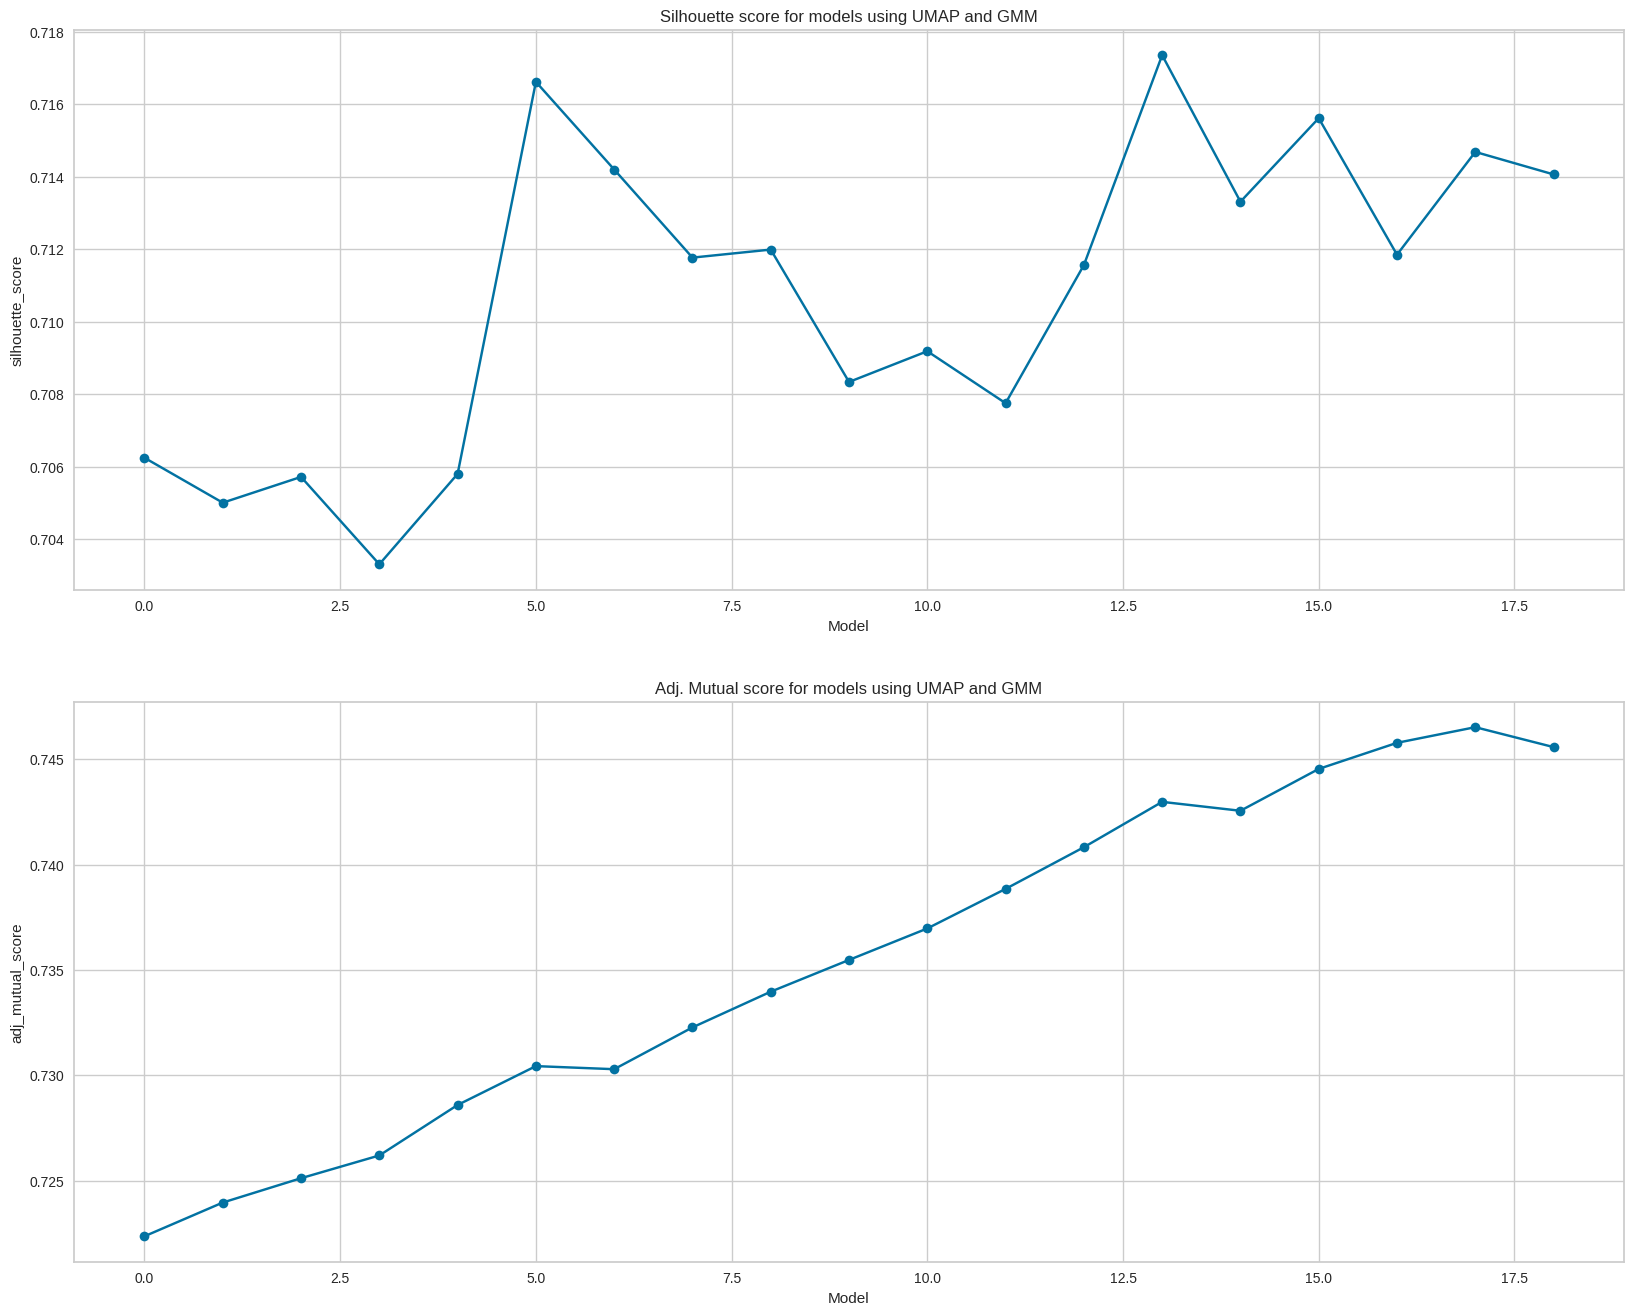

In [153]:
fig, axs = plt.subplots(2,1, figsize=(20, 16))
axs = axs.ravel()


axs[0].plot(range(len(silh_list_gmm_bio)), silh_list_gmm_bio, marker='o')
axs[0].set_xlabel('Model')
axs[0].set_ylabel('silhouette_score')
axs[0].set_title("Silhouette score for models using UMAP and GMM")

axs[1].plot(range(len(adj_list_gmm_bio)), adj_list_gmm_bio, marker='o')
axs[1].set_xlabel('Model')
axs[1].set_ylabel('adj_mutual_score')
axs[1].set_title("Adj. Mutual score for models using UMAP and GMM")

36	-78134.289581	-114841.884570	26.269445	96

**We used aic, bic, and likelihood score of each model along with silhouette, and adj. mutual score to find the best model. Our best model for this was with 96 components. Which seemed appropriate given the comlexity of the texts in our data set. We also looked at the probabilities, and saw that it was actually able to assign right clusters to most of our text. We hoped that will generalize well on test data as well. Again this was not the case**

In [154]:
df_results_gmm[df_results_gmm['components'] > 90].sort_values(by='score', ascending=False)

bic            aic      score  components
49 -77099.057337 -118778.257139  27.433922         109
48 -77275.196379 -118571.965042  27.364228         108
47 -77386.303437 -118300.640961  27.281137         107
46 -77397.558215 -117929.464599  27.177475         106
45 -77434.641920 -117584.117164  27.079134         105
44 -77628.897603 -117395.941708  27.013173         104
43 -77628.435092 -117013.048057  26.907097         103
42 -77864.832128 -116867.013954  26.849817         102
41 -78065.232372 -116684.983058  26.785122         101
40 -77879.766678 -116117.086225  26.640932         100
39 -77967.327593 -115822.216000  26.552991          99
38 -78087.406298 -115559.863565  26.471748          98
37 -78161.516168 -115251.542296  26.381035          97
36 -78134.289581 -114841.884570  26.269445          96
35 -78124.306128 -114449.469977  26.161407          95
34 -78178.661809 -114121.394519  26.066624          94
33 -78309.829296 -113870.130865  25.987666          93
32 -78403.670702 -113581.541132  25.901018          92
31 -78484.635780 -113280.075070  25.811717          91

In [155]:
idx_gmm_best_model = 36

gmm_prediction = gmm_models[idx_gmm_best_model].predict(umap_data)
gmm_proba = gmm_models[idx_gmm_best_model].predict_proba(umap_data)

gmm_prob_list = []

for i in range(gmm_proba.shape[0]):
    proba = gmm_proba[i][np.argmax(gmm_proba[i])]
    gmm_prob_list.append(proba)
    


df_gmm_bio = pd.DataFrame({
    'criterion':df['spacy_wo_stop_punct_lemma'].tolist(),
     'label':gmm_prediction,
      'proba':gmm_prob_list,
      'ground_truth':df['Ground_Truth'].tolist()})

In [156]:
df_gmm_bio

criterion  label  proba  \
0            inability carry pulmonary function testing     91    1.0   
1            inability carry pulmonary function testing     91    1.0   
2              inability perform lung function maneuver     91    1.0   
3     patient unable perform pulmonary function testing     91    1.0   
4           poor performance pulmonary function testing     91    1.0   
...                                                 ...    ...    ...   
2422  patient clinically significant cardiovascular ...     92    1.0   
2423  patient certain cardiovascular co morbid condi...     92    1.0   
2424  subject clinically significant cardiovascular ...     92    1.0   
2425  subject clinically significant cardiovascular ...     92    1.0   
2426                 diagnosis restrictive lung disease      1    1.0   

      ground_truth  
0              0.0  
1              0.0  
2              0.0  
3              0.0  
4              0.0  
...            ...  
2422         104.0  
2423         104.0  
2424         104.0  
2425         104.0  
2426          89.0  

[2427 rows x 4 columns]

### GMM without dimensionality reduction

**The models trained above using UMAP and hdbscan, and GMM worked great on our training data. Visually inspecting it we saw that it was able to cluster similar texts in each cluster. However, they failed to generalize on test data. For each of the test that I performed below, each of them could only assign a few clusters to the whole data even though we had 90+ clusters in each of the models. Did reducing the dimensionality cause a transformation that our model failed to generalize?  Same dimensionality reduction technique was applied on test data.**

**To do a test, I trained GMM models on both sentence embeddings, and bio-bert embedding without any dimensionality reduction**


**GMM with sentence embedding**

In [253]:
gmm_components = np.arange(75,110)

gmm_models_orig = [GaussianMixture(i, covariance_type='full', random_state=1).fit(sen_embed_criterion1) \
                  for i in gmm_components]

In [254]:
bic_list = [model.bic(sen_embed_criterion1) for model in gmm_models_orig]
aic_list = [model.aic(sen_embed_criterion1) for model in gmm_models_orig]
score_list = [model.score(sen_embed_criterion1) for model in gmm_models_orig]
df_results_gmm = pd.DataFrame({
    'bic':bic_list,
    'aic':aic_list,
    'score': score_list,
    'components':gmm_components
    
})

In [255]:
df_results_gmm[df_results_gmm['components'] > 90].sort_values(by='score',ascending=False)

bic           aic        score  components
34  5.255809e+07  5.627740e+06  2177.739672         109
33  5.198454e+07  5.484742e+06  2176.583433         108
32  5.140768e+07  5.338433e+06  2176.109467         107
31  5.082938e+07  5.190686e+06  2175.931503         106
30  5.025562e+07  5.047488e+06  2174.816681         105
29  4.968673e+07  4.909153e+06  2172.699826         104
28  4.910930e+07  4.762274e+06  2172.343191         103
27  4.853437e+07  4.617897e+06  2171.471066         102
26  4.795970e+07  4.473775e+06  2170.546524         101
25  4.738635e+07  4.330983e+06  2169.347935         100
24  4.681165e+07  4.186836e+06  2168.428595          99
23  4.623404e+07  4.039784e+06  2168.107439          98
22  4.567029e+07  3.906586e+06  2164.932424          97
21  4.509431e+07  3.761162e+06  2164.276001          96
20  4.453054e+07  3.627942e+06  2161.105546          95
19  4.395476e+07  3.482720e+06  2160.407574          94
18  4.337648e+07  3.334989e+06  2160.226387          93
17  4.282106e+07  3.210126e+06  2155.334198          92
16  4.224607e+07  3.065685e+06  2154.475310          91

In [256]:
idx_gmm_orig = np.array(df_results_gmm[df_results_gmm['components'] > 90].sort_values(by='score',\
                                                                                 ascending=False).index)

In [258]:
silh_list_gmm_orig = []

for i in idx_gmm_orig:
    score = silhouette_score(sen_embed_criterion1,gmm_models_orig[i].predict(sen_embed_criterion1) ,\
                             metric='cosine')
    silh_list_gmm_orig.append(score)
    
    
adj_list_gmm_orig = []

for i in idx_gmm_orig:
    score = adjusted_mutual_info_score(df['Ground_Truth'], gmm_models_orig[i].predict(sen_embed_criterion1))
    adj_list_gmm_orig.append(score)

Text(0.5, 1.0, 'Adj. Mutual score for models using Sentence Embedding and GMM')

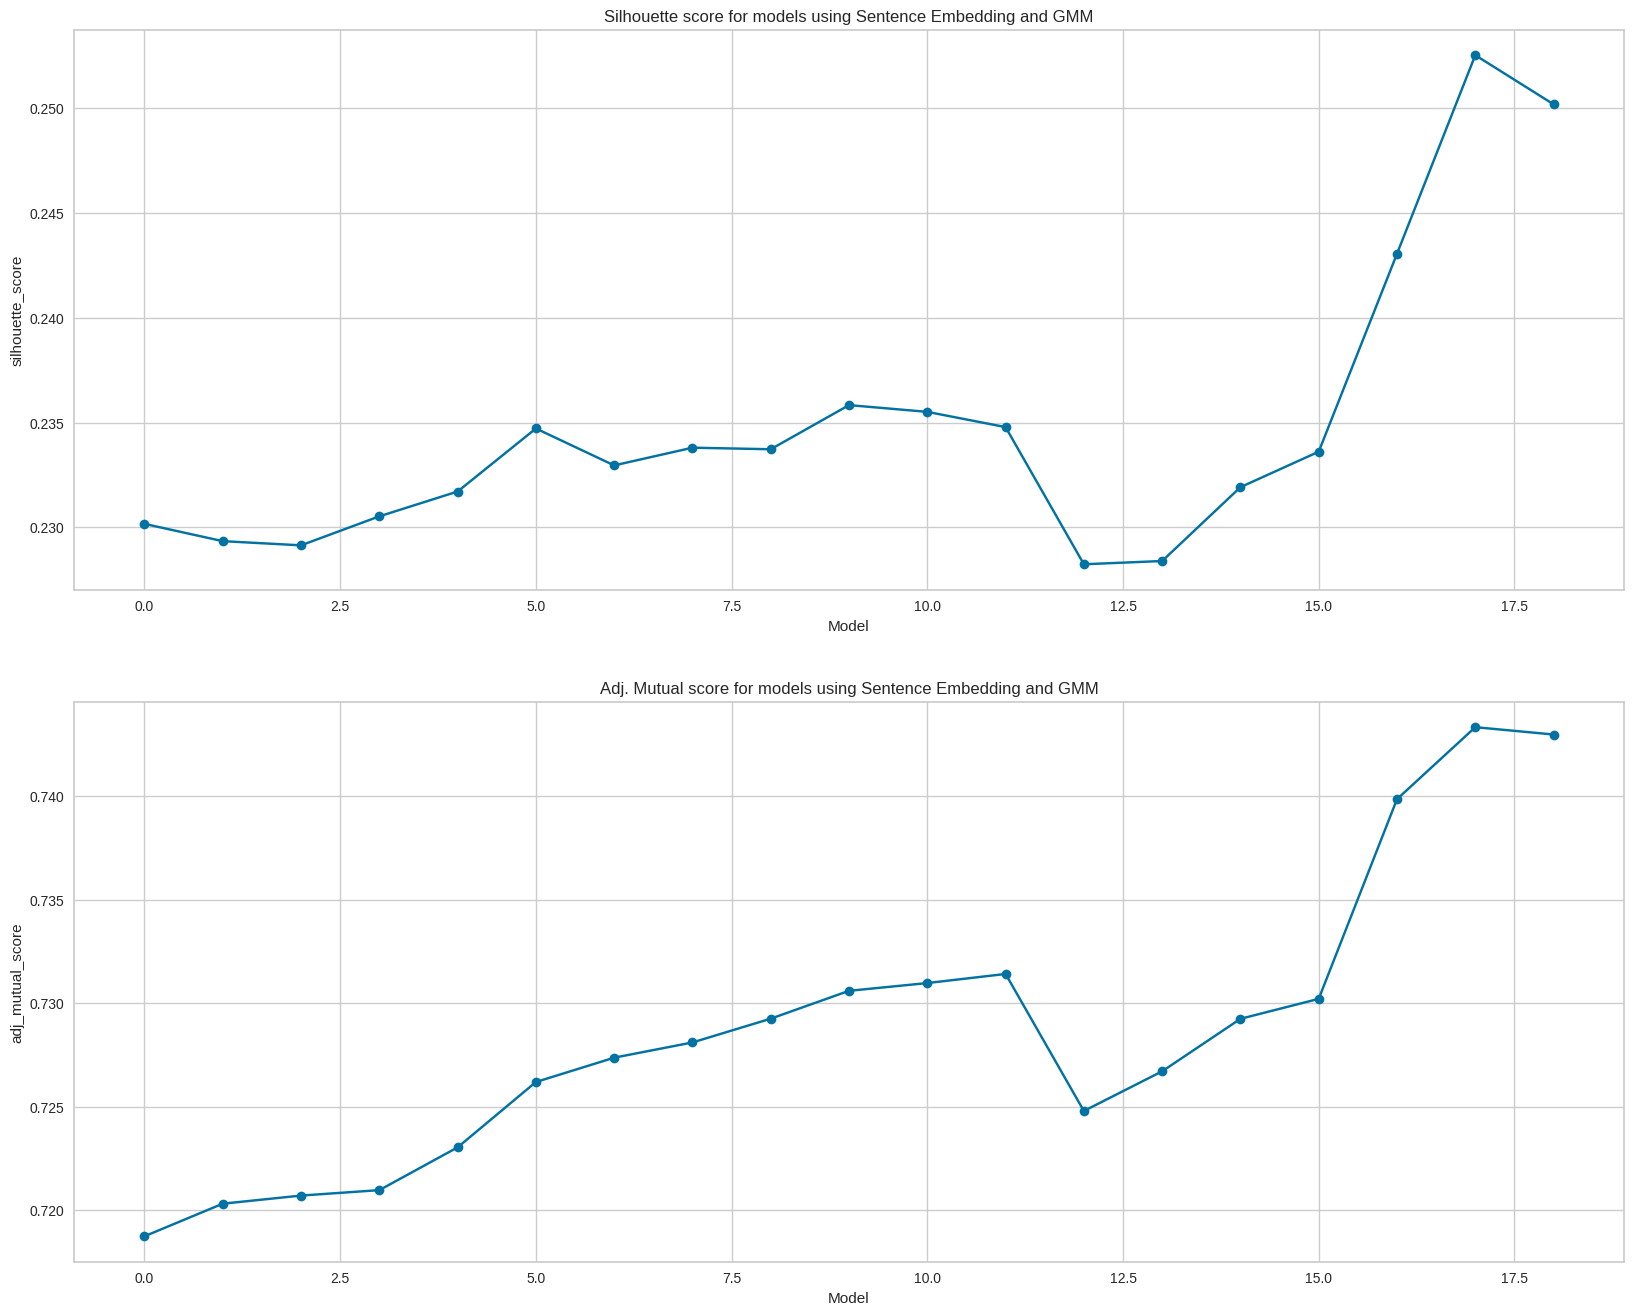

In [259]:
fig, axs = plt.subplots(2,1, figsize=(20, 16))
axs = axs.ravel()


axs[0].plot(range(len(silh_list_gmm_orig)), silh_list_gmm_orig, marker='o')
axs[0].set_xlabel('Model')
axs[0].set_ylabel('silhouette_score')
axs[0].set_title("Silhouette score for models using Sentence Embedding and GMM")

axs[1].plot(range(len(adj_list_gmm_orig)), adj_list_gmm_orig, marker='o')
axs[1].set_xlabel('Model')
axs[1].set_ylabel('adj_mutual_score')
axs[1].set_title("Adj. Mutual score for models using Sentence Embedding and GMM")


**Based on all the metrics, the best model with 92 components was choosen**

In [260]:
idx_best_gmm_sent = 17

### GMM with bio embeddings no dimensionality reduction

In [268]:
gmm_components = np.arange(75,110)

gmm_models_bio = [GaussianMixture(i, covariance_type='full', random_state=1).fit(bio_embed_criterion1) \
                  for i in gmm_components]

In [270]:
bic_list = [model.bic(bio_embed_criterion1) for model in gmm_models_bio]
aic_list = [model.aic(bio_embed_criterion1) for model in gmm_models_bio]
score_list = [model.score(bio_embed_criterion1) for model in gmm_models_bio]
df_results_gmm = pd.DataFrame({
    'bic':bic_list,
    'aic':aic_list,
    'score': score_list,
    'components':gmm_components
    
})

In [271]:
idx_gmm_bio = np.array(df_results_gmm[df_results_gmm['components'] > 90].sort_values(by='score',\
                                                                                 ascending=False).index)

In [272]:
silh_list_gmm_bio = []

for i in idx_gmm_bio:
    score = silhouette_score(bio_embed_criterion1,gmm_models_bio[i].predict(bio_embed_criterion1) ,\
                             metric='cosine')
    silh_list_gmm_bio.append(score)
    
    
adj_list_gmm_bio = []

for i in idx_gmm_bio:
    score = adjusted_mutual_info_score(df['Ground_Truth'], gmm_models_bio[i].predict(bio_embed_criterion1))
    adj_list_gmm_bio.append(score)

Text(0.5, 1.0, 'Adj. Mutual score for models using BioBert Embedding and GMM')

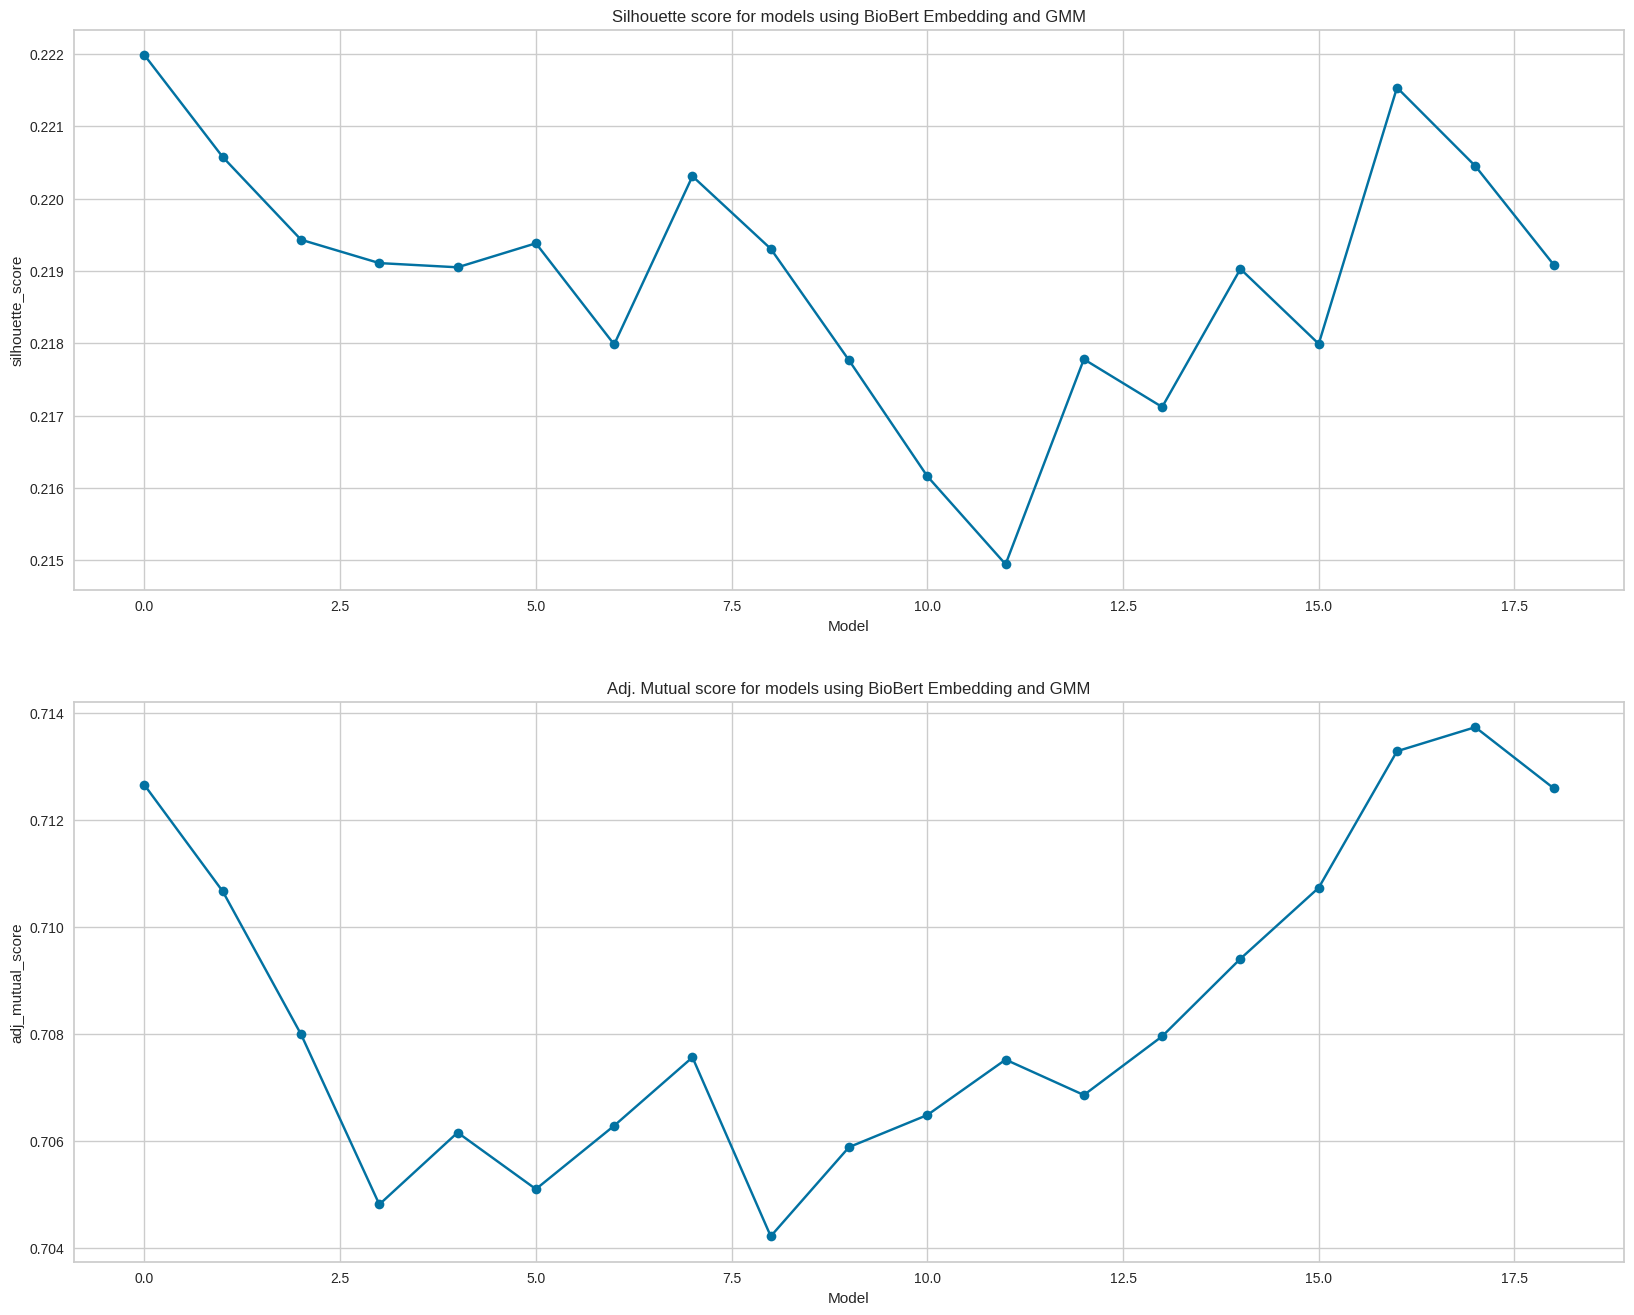

In [273]:
fig, axs = plt.subplots(2,1, figsize=(20, 16))
axs = axs.ravel()


axs[0].plot(range(len(silh_list_gmm_bio)), silh_list_gmm_bio, marker='o')
axs[0].set_xlabel('Model')
axs[0].set_ylabel('silhouette_score')
axs[0].set_title("Silhouette score for models using BioBert Embedding and GMM")

axs[1].plot(range(len(adj_list_gmm_bio)), adj_list_gmm_bio, marker='o')
axs[1].set_xlabel('Model')
axs[1].set_ylabel('adj_mutual_score')
axs[1].set_title("Adj. Mutual score for models using BioBert Embedding and GMM")

**Using similar metrics as above, and GMMs with UMAP, we choose the best model with 92 components**

In [274]:
df_results_gmm[df_results_gmm['components'] > 90].sort_values(by='score',ascending=False)

bic           aic        score  components
34  2.300043e+08  4.301233e+07  4435.484249         109
33  2.277079e+08  4.243152e+07  4433.151733         108
32  2.254022e+08  4.184127e+07  4432.765341         107
31  2.231108e+08  4.126542e+07  4429.409527         106
29  2.185127e+08  4.009836e+07  4425.867670         104
30  2.208207e+08  4.069090e+07  4425.782916         105
28  2.162108e+08  3.951204e+07  4424.670477         103
27  2.139034e+08  3.892016e+07  4424.617627         102
26  2.116017e+08  3.833391e+07  4423.406779         101
25  2.092982e+08  3.774594e+07  4422.550702         100
24  2.069922e+08  3.715545e+07  4422.212248          99
23  2.046880e+08  3.656682e+07  4421.490280          98
21  2.000763e+08  3.538611e+07  4420.759759          96
22  2.023842e+08  3.597858e+07  4420.690587          97
20  1.977771e+08  3.480250e+07  4419.005039          95
19  1.954813e+08  3.422216e+07  4416.575729          94
18  1.931900e+08  3.364639e+07  4413.205208          93
17  1.908871e+08  3.305907e+07  4412.213971          92
16  1.885843e+08  3.247176e+07  4411.220662          91

In [276]:
idx_best_gmm_bio = 17

### Test set data preprocessing and predictions

In [194]:
pd.read_csv("asthma_exclusion.txt", sep='\t')

alzheimer_exclusion = pd.read_excel('data/Alzheimer_Ph23_exclusion.xlsx')
alzheimer_inclusion = pd.read_excel('data/Alzheimer_Ph23_inclusion.xlsx')
alzheimer_outcome = pd.read_csv('data/Alzheimer_Ph23_outcome.txt',sep='\t')

print('='*80 + '\nExclusion\n' + '='*80)
display(alzheimer_exclusion.head(3))
print('='*80 + '\nInclusion\n' + '='*80)
display(alzheimer_inclusion.head(3))
print('='*80 + '\nOutcome\n' + '='*80)
display(alzheimer_outcome.head(3))

Exclusion


NCT#    phase          condition      sponsor start_date  \
0  NCT00000172  Phase 3  Alzheimer Disease  Janssen, LP    unknown   
1  NCT00000172  Phase 3  Alzheimer Disease  Janssen, LP    unknown   
2  NCT00000172  Phase 3  Alzheimer Disease  Janssen, LP    unknown   

                       mesh_list                                  criterion  
0  Alzheimer Disease;Galantamine   Conditions that could confound diagnosis  
1  Alzheimer Disease;Galantamine                Neurodegenerative disorders  
2  Alzheimer Disease;Galantamine                      Acute cerebral trauma

Inclusion


NCT#    phase          condition      sponsor start_date  \
0  NCT00000172  Phase 3  Alzheimer Disease  Janssen, LP    unknown   
1  NCT00000172  Phase 3  Alzheimer Disease  Janssen, LP    unknown   
2  NCT00000172  Phase 3  Alzheimer Disease  Janssen, LP    unknown   

                       mesh_list  \
0  Alzheimer Disease;Galantamine   
1  Alzheimer Disease;Galantamine   
2  Alzheimer Disease;Galantamine   

                                           criterion  
0                       Probable Alzheimer's disease  
1   Mini-Mental State Examination (MMSE) 10-22 an...  
2   Alzheimer's Disease Assessment Scale cognitiv...

Outcome


NCT#    phase            condition  \
0  NCT00010803  Phase 3  Alzheimer's Disease   
1  NCT00010803  Phase 3  Alzheimer's Disease   
2  NCT00010803  Phase 3  Alzheimer's Disease   

                                             sponsor start_date  \
0  National Center for Complementary and Integrat...     Oct-00   
1  National Center for Complementary and Integrat...     Oct-00   
2  National Center for Complementary and Integrat...     Oct-00   

           mesh_list                                          criterion  
0  Alzheimer Disease  Number of Participants With Incident Dementia;...  
1  Alzheimer Disease  Number of Participants With the Indicated Card...  
2  Alzheimer Disease  Progression of Cognitive Decline in Standardiz...

### Preprocessing

In [195]:
def preprocess_data(df):
    df['criterion'] =df['criterion'].replace('[^A-za-z0-9]', ' ', regex=True)
    
    spacy_wo_stop_punct_lemma = []

    for val in df['criterion']:
        doc = nlp(val)
        criterion = ""
    
        for token in doc:
            if not token.is_space:
                if not token.is_stop:
                    if not token.is_punct:
                        if not token.is_digit:
                            criterion +=" "+token.lemma_
        spacy_wo_stop_punct_lemma.append(criterion.strip().lower())
    
                
    df['spacy_wo_stop_punct_lemma'] = spacy_wo_stop_punct_lemma
    return df
    

In [196]:
alzheimer_exclusion = preprocess_data(alzheimer_exclusion)
alzheimer_inclusion = preprocess_data(alzheimer_inclusion)
alzheimer_outcome = preprocess_data(alzheimer_outcome)


In [197]:
print('='*80 + '\nExclusion\n' + '='*80)
display(alzheimer_exclusion.head(3))
print('='*80 + '\nInclusion\n' + '='*80)
display(alzheimer_inclusion.head(3))
print('='*80 + '\nOutcome\n' + '='*80)
display(alzheimer_outcome.head(3))

Exclusion


NCT#    phase          condition      sponsor start_date  \
0  NCT00000172  Phase 3  Alzheimer Disease  Janssen, LP    unknown   
1  NCT00000172  Phase 3  Alzheimer Disease  Janssen, LP    unknown   
2  NCT00000172  Phase 3  Alzheimer Disease  Janssen, LP    unknown   

                       mesh_list                                  criterion  \
0  Alzheimer Disease;Galantamine   Conditions that could confound diagnosis   
1  Alzheimer Disease;Galantamine                Neurodegenerative disorders   
2  Alzheimer Disease;Galantamine                      Acute cerebral trauma   

       spacy_wo_stop_punct_lemma  
0  conditions confound diagnosis  
1     neurodegenerative disorder  
2          acute cerebral trauma

Inclusion


NCT#    phase          condition      sponsor start_date  \
0  NCT00000172  Phase 3  Alzheimer Disease  Janssen, LP    unknown   
1  NCT00000172  Phase 3  Alzheimer Disease  Janssen, LP    unknown   
2  NCT00000172  Phase 3  Alzheimer Disease  Janssen, LP    unknown   

                       mesh_list  \
0  Alzheimer Disease;Galantamine   
1  Alzheimer Disease;Galantamine   
2  Alzheimer Disease;Galantamine   

                                           criterion  \
0                       Probable Alzheimer s disease   
1   Mini Mental State Examination  MMSE  10 22 an...   
2   Alzheimer s Disease Assessment Scale cognitiv...   

                           spacy_wo_stop_punct_lemma  
0                       probable alzheimer s disease  
1  mini mental state examination mmse adas great ...  
2  alzheimer s disease assessment scale cognitive...

Outcome


NCT#    phase            condition  \
0  NCT00010803  Phase 3  Alzheimer's Disease   
1  NCT00010803  Phase 3  Alzheimer's Disease   
2  NCT00010803  Phase 3  Alzheimer's Disease   

                                             sponsor start_date  \
0  National Center for Complementary and Integrat...     Oct-00   
1  National Center for Complementary and Integrat...     Oct-00   
2  National Center for Complementary and Integrat...     Oct-00   

           mesh_list                                          criterion  \
0  Alzheimer Disease  Number of Participants With Incident Dementia ...   
1  Alzheimer Disease  Number of Participants With the Indicated Card...   
2  Alzheimer Disease  Progression of Cognitive Decline in Standardiz...   

                           spacy_wo_stop_punct_lemma  
0  number participants incident dementia cause de...  
1  number participant indicated cardiovascular di...  
2  progression cognitive decline standardized z s...

### Create Embeddings 

In [199]:
def create_sentence_embedding(df):
    model_sentence_transformer = SentenceTransformer("all-MiniLM-L6-v2")
    embeddings_criterion1 = model_sentence_transformer.encode(df['spacy_wo_stop_punct_lemma'].tolist())
    return embeddings_criterion1

def create_biobert_embedding(df):
    model_biobert = 'dmis-lab/biobert-base-cased-v1.2'
    biobert_transformer_model = SentenceTransformer(model_biobert)
    bio_embed_criterion1 = biobert_transformer_model.encode(df['spacy_wo_stop_punct_lemma'].tolist())
    return bio_embed_criterion1

  

In [200]:
#sentence embedding
alzheimer_exclusion_sent_embedding = create_sentence_embedding(alzheimer_exclusion)
alzheimer_inclusion_sent_embedding = create_sentence_embedding(alzheimer_inclusion)
alzheimer_outcome_sent_embedding = create_sentence_embedding(alzheimer_outcome)

#biobert embedding
alzheimer_exclusion_bio_embedding = create_biobert_embedding(alzheimer_exclusion)
alzheimer_inclusion_bio_embedding = create_biobert_embedding(alzheimer_inclusion)
alzheimer_outcome_bio_embedding = create_biobert_embedding(alzheimer_outcome)

No sentence-transformers model found with name /home/riku/.cache/torch/sentence_transformers/dmis-lab_biobert-base-cased-v1.2. Creating a new one with MEAN pooling.
Some weights of the model checkpoint at /home/riku/.cache/torch/sentence_transformers/dmis-lab_biobert-base-cased-v1.2 were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly iden

### Dimensionality reduction with UMAP

In [203]:
def umap_reduce_dimension(embedding, emb_type):
    
    if emb_type =='sent':
        umap_fit = umap.UMAP(n_neighbors=8, n_components= 8, \
                                random_state=1, metric='cosine').fit_transform(embedding)
    
    if emb_type=='bio':
        umap_fit = umap.UMAP(n_neighbors=12, n_components= 10, \
                             random_state=1, metric='cosine').fit_transform(embedding)
        
    return umap_fit
        
        
    


In [204]:
#hdbscan with sentence embedding umap

alzheimer_exclusion_umap_sent = umap_reduce_dimension(alzheimer_exclusion_sent_embedding, 'sent')
alzheimer_inclusion_umap_sent = umap_reduce_dimension(alzheimer_inclusion_sent_embedding, 'sent')
alzheimer_outcome_umap_sent = umap_reduce_dimension(alzheimer_outcome_sent_embedding, 'sent')

alzheimer_exclusion_umap_bio = umap_reduce_dimension(alzheimer_exclusion_bio_embedding, 'bio')
alzheimer_inclusion_umap_bio = umap_reduce_dimension(alzheimer_inclusion_bio_embedding, 'bio')
alzheimer_outcome_umap_bio = umap_reduce_dimension(alzheimer_outcome_bio_embedding, 'bio')




### Test Predictions using the selected models with Dimensional Reduction

In [281]:
#Test for hdbscan best model with sentence embedding and umap

alz_exc_lab, strength = hdbscan.approximate_predict(hdbscan_list[71], alzheimer_exclusion_umap_sent)

alz_inc_lab, strength = hdbscan.approximate_predict(hdbscan_list[71], alzheimer_inclusion_umap_sent)

alz_out_lab, strength = hdbscan.approximate_predict(hdbscan_list[71], alzheimer_outcome_umap_sent)


#Test for gmm model with bio-bert embedding and umap

alz_exc_gmm = gmm_models[idx_gmm_best_model].predict(alzheimer_exclusion_umap_bio)

#alzheimer inclusion prediction
alz_inc_gmm = gmm_models[idx_gmm_best_model].predict(alzheimer_inclusion_umap_bio)

#alzheimer outcome prediction
alz_out_gmm = gmm_models[idx_gmm_best_model].predict(alzheimer_outcome_umap_bio)


In [285]:
print("unique clusters in hdbscan with alzheimer exclusion test data")
print(np.unique(alz_exc_lab))

print("Total assigned cluster")
print(np.sum(alz_exc_lab !=-1))

print("unique clusters in hdbscan with alzheimer inclusion test data")
print(np.unique(alz_inc_lab))

print("Total assigned cluster")
print(np.sum(alz_inc_lab !=-1))

print("unique clusters in hdbscan with alzheimer exclusion test data")
print(np.unique(alz_out_lab))

print("Total assigned cluster")
print(np.sum(alz_out_lab !=-1))


unique clusters in hdbscan with alzheimer exclusion test data
[-1  1]
Total assigned cluster
18
unique clusters in hdbscan with alzheimer inclusion test data
[-1  1  2  6  8 14]
Total assigned cluster
150
unique clusters in hdbscan with alzheimer exclusion test data
[-1  2  9]
Total assigned cluster
26


**As seem from the above results the hdbscan failed to generalize on the new data. For inclusion data it was atleast able to assign 5 clusters, and considered rest  as noise. The model with asthma data had over 90 clusters**

In [289]:
print("unique clusters in hdbscan with alzheimer exclusion test data")
print(np.unique(alz_exc_gmm))

print("Total assigned cluster")
print(len(np.unique(alz_exc_gmm)))

print("unique clusters in hdbscan with alzheimer inclusion test data")
print(np.unique(alz_inc_gmm))

print("Total assigned cluster")
print(len(np.unique(alz_inc_gmm)))

print("unique clusters in hdbscan with alzheimer exclusion test data")
print(np.unique(alz_out_gmm))

print("Total assigned cluster")
print(len(np.unique(alz_out_gmm)))


unique clusters in hdbscan with alzheimer exclusion test data
[ 2 14 17 28 35 36 37 43 62 69 70 72 73 75 77 79 88 92]
Total assigned cluster
18
unique clusters in hdbscan with alzheimer inclusion test data
[ 2  3 14 17 20 31 35 36 37 43 44 47 53 59 62 65 68 69 71 72 73 75 77 79
 84]
Total assigned cluster
25
unique clusters in hdbscan with alzheimer exclusion test data
[ 2 20 22 28 31 35 37 41 62 67 69 70 72 73 77 79]
Total assigned cluster
16


**Similar situation for GMM with dimensionality reduction. It only assigned the test data to few clusters, although the model was trained to have over 90 clusters.**

In [238]:
#alzheimers exclusion predictions
alz_exc_gmm = gmm_models[idx_gmm_best_model].predict(alzheimer_exclusion_umap_bio)

#alzheimer inclusion prediction
alz_inc_gmm = gmm_models[idx_gmm_best_model].predict(alzheimer_inclusion_umap_bio)

#alzheimer outcome prediction
alz_out_gmm = gmm_models[idx_gmm_best_model].predict(alzheimer_outcome_umap_bio)


**Both models did not generalize well. These models were not selected.**

### Test Prediction using no dimensionality reduction GMM

In [290]:
#alzheimers exclusion predictions
alz_exc_gmm = gmm_models_orig[idx_best_gmm_sent].predict(alzheimer_exclusion_sent_embedding)

#alzheimer inclusion prediction
alz_inc_gmm = gmm_models_orig[idx_best_gmm_sent].predict(alzheimer_inclusion_sent_embedding)

#alzheimer outcome prediction
alz_out_gmm = gmm_models_orig[idx_best_gmm_sent].predict(alzheimer_outcome_sent_embedding)


#alzheimers exclusion predictions
alz_exc_gmm_bio = gmm_models_bio[idx_best_gmm_bio].predict(alzheimer_exclusion_bio_embedding)

#alzheimer inclusion prediction
alz_inc_gmm_bio = gmm_models_bio[idx_best_gmm_bio].predict(alzheimer_inclusion_bio_embedding)

#alzheimer outcome prediction
alz_out_gmm_bio = gmm_models_bio[idx_best_gmm_bio].predict(alzheimer_outcome_bio_embedding)


In [291]:
print("unique clusters in gmm with alzheimer exclusion test data and sentence embedding")
print(np.unique(alz_exc_gmm))

print("Total assigned cluster")
print(len(np.unique(alz_exc_gmm)))

print("unique clusters in gmm with alzheimer exclusion test data and sentence embedding")
print(np.unique(alz_inc_gmm))

print("Total assigned cluster")
print(len(np.unique(alz_inc_gmm)))

print("unique clusters in gmm with alzheimer exclusion test data and sentence embedding")
print(np.unique(alz_out_gmm))

print("Total assigned cluster")
print(len(np.unique(alz_out_gmm)))

unique clusters in hdbscan with alzheimer exclusion test data
[ 2  6  7  8  9 10 12 13 14 15 16 17 18 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 35 37 38 39 40 41 42 43 44 45 46 47 48 49 50 53 54 55 57 58 59
 60 61 64 65 66 67 68 69 70 72 73 74 75 78 81 82 83 84 87 88 89 90 91]
Total assigned cluster
71
unique clusters in hdbscan with alzheimer inclusion test data
[ 2  6  7  9 10 12 15 16 17 18 19 20 21 26 28 30 31 33 35 38 39 42 43 44
 46 48 49 50 51 54 55 57 60 61 64 65 66 67 68 70 73 74 75 82 83 84 87 88]
Total assigned cluster
48
unique clusters in hdbscan with alzheimer exclusion test data
[ 2  6  7  9 15 16 20 22 25 28 30 31 33 35 38 39 42 43 44 46 48 49 50 55
 57 61 64 65 66 67 70 72 75 78 83 84 90 91]
Total assigned cluster
38


**GMM with sentence embedding and no dimensional reduction was better at assigning clusters to each case. It did well on exclusion data. It had moderate performance on inclusion data and somewhat poor performance on outcome data.**

In [296]:
print("unique clusters in gmm with alzheimer exclusion test data and Bio-Bert embedding")
print(np.unique(alz_exc_gmm_bio))

print("Total assigned cluster")
print(len(np.unique(alz_exc_gmm_bio)))

print("unique clusters in gmm with alzheimer exclusion test data and Bio-Bert embedding")
print(np.unique(alz_inc_gmm_bio))

print("Total assigned cluster")
print(len(np.unique(alz_inc_gmm_bio)))

print("unique clusters in gmm with alzheimer exclusion test data and Bio-Bert embedding")
print(np.unique(alz_out_gmm_bio))

print("Total assigned cluster")
print(len(np.unique(alz_out_gmm_bio)))

unique clusters in gmm with alzheimer exclusion test data and Bio-Bert embedding
[ 0  1  2  3  4  5  6  7  9 11 12 13 14 15 17 18 19 20 21 22 23 25 26 27
 28 29 30 33 34 35 36 38 40 41 42 43 44 45 46 47 48 49 50 51 52 53 55 56
 57 58 59 60 61 62 63 64 65 66 67 69 70 72 73 74 75 76 77 78 79 80 82 83
 84 85 86 88 90 91]
Total assigned cluster
78
unique clusters in gmm with alzheimer exclusion test data and Bio-Bert embedding
[ 1  3  4  5  6  7 10 11 12 13 15 18 19 20 21 22 23 25 26 27 28 30 33 34
 35 37 38 40 42 43 44 46 47 48 49 50 51 52 56 57 58 59 61 63 64 65 66 67
 68 70 75 76 77 80 82 83 84 90]
Total assigned cluster
58
unique clusters in gmm with alzheimer exclusion test data and Bio-Bert embedding
[ 1  3  4  6  7 12 13 15 16 20 21 22 23 25 26 27 28 30 34 40 42 44 47 48
 49 50 51 56 57 59 61 63 64 65 70 72 82 84 88 90]
Total assigned cluster
40


**GMM trained with Bio-bert embeddings with no dimensional reduction was able to perform much better compared to other models trained. It did a good job in assigning sentences in the exclusion dataset. It also performed moderate on both inclusion and outcome data. This is the final model from our experimentation with density based clustering technique with probabilities.**

In [293]:
gmm_models_bio[idx_best_gmm_bio]

GaussianMixture(n_components=92, random_state=1)

**Our model from this part is GaussianMixture model with n_components i.e. number of cluster =92**

### Write Output

In [305]:
df_exclusion_result = pd.read_csv("data/KumarNitesh_PhamJanice_exclusion.csv")
df_exclusion_result['GMM_BioBert'] = alz_exc_gmm_bio

df_exclusion_result.to_csv("data/KumarNitesh_PhamJanice_exclusion.txt", sep='\t', index=False)


In [306]:
df_inclusion_result = pd.read_csv("data/KumarNitesh_PhamJanice_inclusion.csv")
df_inclusion_result['GMM_BioBert'] = alz_inc_gmm_bio

df_inclusion_result.to_csv("data/KumarNitesh_PhamJanice_inclusion.txt", sep='\t', index=False)

In [307]:
df_out_result = pd.read_csv("data/KumarNitesh_PhamJanice_outcome.csv")
df_out_result['GMM_BioBert'] = alz_out_gmm_bio

df_out_result.to_csv("data/KumarNitesh_PhamJanice_outcome.txt", sep='\t', index=False)

**Thank you**